# SENTIMENT ANALYSIS ON IMDB MOVIE REVIEWS

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16,ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, UpSampling2D, BatchNormalization, GlobalAveragePooling2D, MaxPool2D, Conv2DTranspose, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_datasets as tfds
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import os
import tensorflow.image as tfi
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import pickle
from wordcloud import WordCloud, STOPWORDS

# Dataset Loading

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

In [4]:
train_dataset, test_dataset = dataset['train'], dataset['test']
train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [6]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Text Preprocessing

In [7]:
text, label = [],[]
for i in train_dataset:
    text.append(i[0].numpy())
    label.append(i[1].numpy())
text = np.concatenate(text)
label = np.concatenate(label)

In [8]:
text = [str(i) for i in text]
text = [i.replace("b'",'').replace('b"','').replace('\'','').replace('"','') for i in text]
label = [i for i in label]

In [9]:
text = np.array(text)
label = np.array(label)

In [10]:
vocab_size = 10000
textVector = tf.keras.layers.TextVectorization(max_tokens=vocab_size)
textVector.adapt(text)

In [11]:
words = textVector.get_vocabulary()

In [12]:
text_test, label_test = [],[]
for i in test_dataset:
    text_test.append(i[0].numpy())
    label_test.append(i[1].numpy())
text_test = np.concatenate(text_test)
label_test = np.concatenate(label_test)

In [13]:
text_test = [str(i) for i in text_test]
text_test = [i.replace("b'",'').replace('b"','').replace('\'','').replace('"','') for i in text_test]
label_test = [i for i in label_test]

In [14]:
text_test = np.array(text_test)
label_test = np.array(label_test)

# Most frequent words visualisation

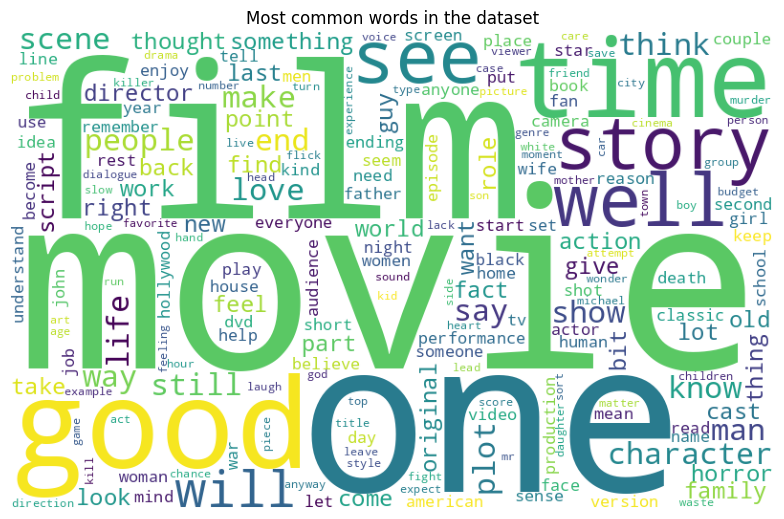

In [15]:
wordcloud = WordCloud(width = 800, height = 500,
                background_color ='white',
                stopwords = STOPWORDS,
                min_font_size = 10).generate(' '.join(words))

plt.figure(figsize = (8,5), facecolor = None)
plt.title('Most common words in the dataset')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [16]:
# max_len = max([len(i) for i in text])
max_len = 120

In [17]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(text)
text = tokenizer.texts_to_sequences(text)
text = tf.keras.preprocessing.sequence.pad_sequences(text, maxlen=max_len, padding='post', truncating='post')

## Model Training

In [18]:
model = Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 64, input_length=max_len))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 64)           640000    
                                                                 
 bidirectional (Bidirection  (None, 120, 128)          66048     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 751489 (2.87 MB)
Trainable params: 751489 

In [20]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
model.fit(text, label, epochs=10, validation_split=0.2, batch_size=64, callbacks=[EarlyStopping(patience=2)])

Epoch 1/10
313/313 [==============================] - 37s 111ms/step - loss: 0.4798 - accuracy: 0.7579 - val_loss: 0.3648 - val_accuracy: 0.8338
Epoch 2/10
313/313 [==============================] - 34s 110ms/step - loss: 0.2779 - accuracy: 0.8879 - val_loss: 0.3638 - val_accuracy: 0.8460
Epoch 3/10
313/313 [==============================] - 39s 124ms/step - loss: 0.1838 - accuracy: 0.9300 - val_loss: 0.4378 - val_accuracy: 0.8316
Epoch 4/10
313/313 [==============================] - 35s 111ms/step - loss: 0.1066 - accuracy: 0.9632 - val_loss: 0.5390 - val_accuracy: 0.8370


In [22]:
tokenizer.fit_on_texts(text_test)
text_test = tokenizer.texts_to_sequences(text_test)
text_test = tf.keras.preprocessing.sequence.pad_sequences(text_test, maxlen=max_len, padding='post', truncating='post')
model.evaluate(text_test, label_test)

782/782 [==============================] - 12s 16ms/step - loss: 1.5302 - accuracy: 0.5781


[1.5301687717437744, 0.5780799984931946]

In [23]:
model.evaluate(text, label)

782/782 [==============================] - 12s 15ms/step - loss: 0.1565 - accuracy: 0.9518


[0.1565399169921875, 0.9517999887466431]

## Prediction

In [24]:
def out_pred(x):
    if x>0.5:
        return 1
    else:
        return 0
label_sentiment = ["Negative","Positive"]

In [31]:
sample_sentence = ['The movie was great', 'The movie was bad, I hated it']
sant = sample_sentence.copy()
sample_sentence = tokenizer.texts_to_sequences(sample_sentence)
sample_sentence = tf.keras.preprocessing.sequence.pad_sequences(sample_sentence, maxlen=max_len, padding='post', truncating='post')
pred = model.predict(sample_sentence)
for i in range(len(pred)):
    print(sant[i], ' : ', label_sentiment[out_pred(pred[i])])

1/1 [==============================] - 0s 18ms/step
The movie was great  :  Positive
The movie was bad, I hated it  :  Negative
